This notebook contains code to make the plots shown in Figure 5e, 5h, and 6h to depict data from individual sgRNA validation. These plots use the data from the "Nucleotide_percentage_table.txt" that is generated by CRISPResso2. First, the raw data are processed (see notebook BEV_nucleotide_percentage_plots) to include information about the "offset_position" (i.e. the position of each nucleotide relative to the sgRNA).

In this notebook, the processed "nucleotide_percentage" files are used to calculate the change in C>T editing % between "test" conditions and "reference" conditions. For validation experiments with small molecules, the "test" condition is a treated condition and the "reference" condition is an untreated condition (usually time-matched). For validation experiments without small molecules (i.e. BRCA1 / BRCA2), the "test" condition is a late timepoint and the "reference" condition is an early timepoint.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import base_edit_functions as be
from math import log
from os import path
import csv
mpl.rc('pdf', fonttype=42)
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
sns.set_context('paper')
sns.set_style('ticks')

In [2]:
def get_files(bev_test, bev_ref, primer):
    ref = pd.read_csv('../Data/Validation_CRISPResso_results/nucleotide_percentage/BEV_' 
                      + str(bev_ref[0]) + '_' + str(bev_ref[1]) + '_' + primer + '.csv')
    test = pd.read_csv('../Data/Validation_CRISPResso_results/nucleotide_percentage/BEV_'
                       + str(bev_test[0]) + '_' + str(bev_test[1]) + '_' + primer + '.csv')
    return pd.merge(ref, test, on = ['position', 'offset_position', 'WT'])

def eliminate_non_C(row,col):
    if row['WT'] != 'C':
        return np.nan
    else:
        return row[col]
    
def get_diff(df,bev_test,bev_ref):
    
    col1 = 'T_'+str(bev_test[0])+'-'+str(bev_ref[0])
    col2 = 'T_'+str(bev_test[1])+'-'+str(bev_ref[1])
    
    df[col1] = (df['T_'+str(bev_test[0])] - df['T_'+str(bev_ref[0])]) * 100
    df[col2] = (df['T_'+str(bev_test[1])] - df['T_'+str(bev_ref[1])]) * 100
    
    df[col1+'_CT'] = df.apply(eliminate_non_C,axis=1,args=(col1,))
    df[col2+'_CT'] = df.apply(eliminate_non_C,axis=1,args=(col2,))
    df['T_diff_avg'] = df[[col1+'_CT',col2+'_CT']].mean(axis=1)
    
    return df,col1+'_CT',col2+'_CT'

# Returns absolute positions in the amplicon in order to shade region between positions 4 and 8 in the sgRNA
def get_shaded_region(data):
    start = data.loc[data['offset_position'].isin([3,4]),'position'].mean()
    end = data.loc[data['offset_position'].isin([8,9]),'position'].mean()
    return start, end
    
def make_diff_plot(df,col1,col2,output_name,xlims,ylims,color_num,figsize):
    fig,ax = plt.subplots(figsize=figsize)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xticks([])
    # Plot average of 2 replicates as bar
    ax.bar(df['position'], df['T_diff_avg'], width=1, color=sns.color_palette('Set2')[7],
           zorder=2,linewidth=0.5,edgecolor='black')
    # Plot individual replicates as dots
    ax.scatter(df['position'],df[col1],color='black',zorder=4,s=4)
    ax.scatter(df['position'],df[col2],color='black',zorder=3,s=4)
    # Shade the window of expected editing (positions 4 to 8 in the sgRNA)
    lims = get_shaded_region(df)
    ax.axvspan(lims[0],lims[1],alpha=0.5,color=sns.color_palette('Set2')[color_num],zorder=1)
    # Line at 0
    ax.axhline(0,linewidth=0.5,color='black')
    sns.despine(top=True,bottom=True,right=True)
    plt.tight_layout()
    fig.savefig('../Data/Validation_CRISPResso_results/diff_plots/'+output_name+'.pdf',transparent=True)
    return

def run():
    input_file = pd.read_csv('../Data/Validation_CRISPResso_results/diff_plots/diff_plots_input.csv')
    for i,r in input_file.iterrows():
        bev_test = r['bev_test'].split(';')
        bev_ref = r['bev_ref'].split(';')
        df = get_files(bev_test=bev_test,bev_ref=bev_ref,primer=r['primer'])
        df,col1,col2 = get_diff(df=df,bev_test=bev_test,bev_ref=bev_ref)
        make_diff_plot(df=df,col1=col1,col2=col2,xlims=(r['xlim1'],r['xlim2']),
                       ylims=(r['ylim1'],r['ylim2']),color_num=r['color_num'],
                       output_name=r['output_name'],figsize=(r['fig_width'],r['fig_height']))
    return df


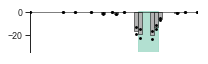

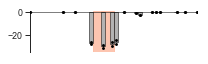

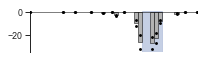

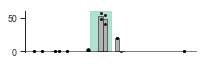

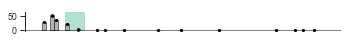

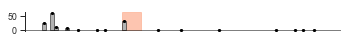

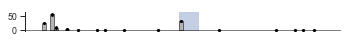

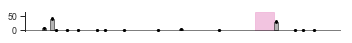

In [3]:
df = run()